### Deriving pulsar properties from PWNe - testing
* Pair-production multiplicity via de Jager 2007 $<k> = \frac{N_e({\rm obs})}{2N_{GJ}}$
* Initial spin-down period $P_0$ via van de Swaluw 2001 & the ratio $R_{pwn}/R_{snr}$
* Relate $k$ to the fraction of hadronic particles present in the PWN (and hence hadronic emission component) 

In [1]:
import numpy as np
import astropy.units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from psrqpy import QueryATNF
import matplotlib.pylab as pylab
from cycler import cycler
from itertools import cycle
from scipy.integrate import simps
from matplotlib.pyplot import cm


params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

pylab.rcParams.update(params)
plt.style.use('tableau-colorblind10')

%matplotlib inline

In [2]:
# Choose parameters from ATNF (or query the whole database)
query = QueryATNF() #params=['Edot','age',"dist","P0","P1","BINARY"])

In [3]:
# Convert them to PANDAS
table = query.table
table = table.to_pandas()

age_all = table["AGE"]
edot_all = table["EDOT"]
dist = table["DIST"]
period = table["P0"]
pdot = table["P1"]
#fatnf = 2*np.pi/np.asarray(period)/u.s

# Compute beam fraction correction
beam_fraction = 9 * np.power(np.log10((period)/10), 2) + 3
beam_fraction /= 100

# Selection to remove milli-second pulsars
sel = np.logical_and(np.invert(np.isnan(age_all)), np.invert(np.isnan(edot_all)))
sel = np.logical_and(sel, dist < 25) #within the Milky Way
sel = np.logical_and(sel, period > 0.01)
sel = np.logical_and(sel, pdot > 1e-18)
sel = np.logical_and(sel, age_all < 1e7)

#print(max(age))
#Now apply selection mask 
age_all = age_all[sel]

edot_all = edot_all[sel]
beam_fraction = beam_fraction[sel]
#dist = dist[sel]
#period = period[sel]
#pdot = pdot[sel]

### Pair-production mutiplicity
1) Use Halo paper results for known HESS PWNe to obtain $N_e$ via observations 
* i.e. use energy densities provided and properties of the assumed electron spectrum 
* Note: $E_{\rm min} = 100$GeV, $E_{\rm max}=1,3,10$TeV and $\Gamma = 2.2$

2) Use ATNF catalogue to obtain $N_{GJ}$ for the same pulsars via known properties
* see also eqn(2) of de Jager for the simplified version of $\dot{E}$


In [4]:
import pandas as pd

df = pd.read_csv("Pulsar_PWNe_properties - table_pulsars.csv")

In [5]:
df.columns

Index(['Name', 'ATNF J name', 'Edot [erg/s]', 'Size [pc]', 'Distance [kpc]',
       'Age [kyr]', 'Total_E [erg]', 'Volume [cm^3]', 'Edens [eV/cm^-3]',
       'mean_edens [eV/cm^-3]', 'min_edens [eV/cm^-3]', 'max_edens [eV/cm^-3]',
       'E_Threshold [TeV]', 'R_SNR [pc]', 'R_PWN [pc]', 'R_TeV [pc]',
       'R_Xray [pc]', 'LHAASO E_gmax (PeV)', 'LHAASO E_emax (PeV)',
       'Unnamed: 19', 'dN_e/dE', 'E_low [TeV]', 'E_0 [TeV]', 'E_max [TeV]',
       'N_e [cm^-3]', 'Notes', 'Unnamed: 26'],
      dtype='object')

In [6]:
#Obtain period and pdot from ATNF
atnf_names=df['ATNF J name']

period_atnf = np.zeros(len(df))
pdot_atnf = np.zeros(len(df))
print(table["NAME"][sel])
for i in range(len(df)):
    psr_idx = np.where(table["NAME"]==atnf_names[i])[0][0]
    period_atnf[i] = period[psr_idx]
    pdot_atnf[i] = pdot[psr_idx]


0       J0002+6216
1       J0006+1834
2       J0007+7303
45      J0040+5716
49      J0048+3412
           ...    
3335    J2325+6316
3342    J2330-2005
3345    J2337+6151
3355    J2354+6155
3358    J2355+2246
Name: NAME, Length: 1244, dtype: object


In [7]:
#Define properties of electron spectrum as per the halos paper
E0 = 1. *u.TeV
E2 = 10. *u.TeV #1, 3 or 10
#E1 = 0.1 *u.TeV
E1 = df['E_Threshold [TeV]']*u.TeV
Gam = 2.2

pow2 = 2-Gam
integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))

#Integration constant is total energy (from halos paper) divided by electron spectrum integral
print(df['E_Threshold [TeV]'])
k_intconst = df["Total_E [erg]"]*u.erg / integral2

0       NaN
1       NaN
2     0.387
3     0.388
4     0.610
5     0.894
6     0.759
7     0.501
8     0.395
9     0.470
10    0.388
11    0.759
12    0.784
13    0.396
14    0.683
15    0.694
16      NaN
17    0.170
18      NaN
19      NaN
20    0.532
21    0.742
22      NaN
23    0.492
24    0.442
25    0.442
26    0.428
27    0.587
28    0.757
29    0.757
30    0.383
31    0.383
32      NaN
33    0.389
34    0.744
35    0.388
36    0.388
37    0.492
38      NaN
39      NaN
40    0.379
41    0.379
42      NaN
43      NaN
44      NaN
45      NaN
46      NaN
47      NaN
Name: E_Threshold [TeV], dtype: float64


In [8]:
pow1 = 1-Gam
integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1

Nel = k_intconst*integral
#Number of electrons derived from observations
print(Nel[0])

nan


In [9]:
#for convenience
yr_to_s = (1. * u.yr).to(u.s)

In [10]:
#Edot and age as used in halos paper: 
edot = np.zeros(len(df))
age_halo = np.zeros(len(df))

for i in range(len(df)):
#     print(i)
    edot[i] = df["Edot [erg/s]"][i] 
    age_halo[i] = df["Age [kyr]"][i]
    

edot *= u.erg / u.s
age_halo *= u.kyr
# print(age_halo)

In [11]:
#Calculate age as a function of P0

def age_p0(psr_period,psr_pdot,p0=0.01*u.s,n=3):
    
    brk = n-1
    argp = p0/(psr_period*u.s)
    tau_age = 1. - argp**brk
    tau_age *= (psr_period*u.s)/(brk*psr_pdot)
    return tau_age.to(u.yr)

In [12]:
#Range of initial spin periods 
test_p0 = np.linspace(0.01,0.15,150)*u.s
print(test_p0)

[0.01       0.0109396  0.01187919 0.01281879 0.01375839 0.01469799
 0.01563758 0.01657718 0.01751678 0.01845638 0.01939597 0.02033557
 0.02127517 0.02221477 0.02315436 0.02409396 0.02503356 0.02597315
 0.02691275 0.02785235 0.02879195 0.02973154 0.03067114 0.03161074
 0.03255034 0.03348993 0.03442953 0.03536913 0.03630872 0.03724832
 0.03818792 0.03912752 0.04006711 0.04100671 0.04194631 0.04288591
 0.0438255  0.0447651  0.0457047  0.0466443  0.04758389 0.04852349
 0.04946309 0.05040268 0.05134228 0.05228188 0.05322148 0.05416107
 0.05510067 0.05604027 0.05697987 0.05791946 0.05885906 0.05979866
 0.06073826 0.06167785 0.06261745 0.06355705 0.06449664 0.06543624
 0.06637584 0.06731544 0.06825503 0.06919463 0.07013423 0.07107383
 0.07201342 0.07295302 0.07389262 0.07483221 0.07577181 0.07671141
 0.07765101 0.0785906  0.0795302  0.0804698  0.0814094  0.08234899
 0.08328859 0.08422819 0.08516779 0.08610738 0.08704698 0.08798658
 0.08892617 0.08986577 0.09080537 0.09174497 0.09268456 0.0936

In [13]:
#Calculate N_GJ integral, check current day values

def calc_ngj(edot_pwn,age_pwn):
    
    ngj_integrand = (6. * c.c * edot_pwn)**0.5 
    ngj_integrand /= c.e.gauss
    ngj_out = ngj_integrand.to(1./u.s)*age_pwn.to(u.s)
        
    return ngj_out#.to(1.)
'''
#Plot edot (PWN,t), from Gunn and Ostriker, assumes theta=pi/4
def calc_ngj(age_pwn,patnf,Bp=10**12*u.cm**-0.5*u.g**0.5/u.s,a=(10*u.km).to(u.cm),theta=np.pi/4,I=1.4e45*u.g*u.cm**2):
    ys=np.arange(len(age_pwn),dtype='float64')
    fatnfc=2*np.pi/patnf/u.s
    print(patnf,fatnfc)
    for i in np.arange(len(ys)):
        t=np.linspace(0*u.s,age_pwn[i].to(u.s),100)
        tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnfc**2)
        edot_pwn=(2/(3*c.c.cgs**3))*(Bp**2*(a**6)/4)*((np.sin(theta)**2*fatnfc**4)/(1+2*t/tau0atnf)**2)
        edot_pwn=edot_pwn.to(u.erg/u.s)
        integrand=1*(6*c.c.cgs*edot_pwn)**0.5/c.e.gauss
        y=simps(integrand,t)
        ys[i]=y
    return ys
'''

0.3849286233650379 16.32298801853734 1 / s
0.2370994416922568 26.500211313592406 1 / s
0.04474055970362699 140.436001444797 1 / s
0.06188365001063282 101.53223518813148 1 / s
0.15158194339345915 41.45075044242182 1 / s
0.136855046957 45.91124293102446 1 / s
0.06817987659 92.15600880247335 1 / s
0.038522586319205 163.10393220008635 1 / s
0.3265712883437141 19.239858283458698 1 / s
0.08932838502359318 70.33806001888524 1 / s
0.070498243969 89.12541580386704 1 / s
0.11057301169006639 56.82385973885933 1 / s
0.1661083275067481 37.82582969492805 1 / s
0.10148679420759428 61.91135857860622 1 / s
0.4079629835557105 15.401361301010215 1 / s
0.18452809508644874 34.0500198857849 1 / s
0.033392412302258895 188.16206658883846 1 / s
0.052152855 120.4763441460604 1 / s
0.06571592849324429 95.61129928835304 1 / s
0.3158731908527248 19.89148015448107 1 / s
0.069356847 90.59214164074653 1 / s
0.11147243434221338 56.36537269734867 1 / s
0.064667 97.1621585535062 1 / s
0.08090668906 77.65965188020496 1 /

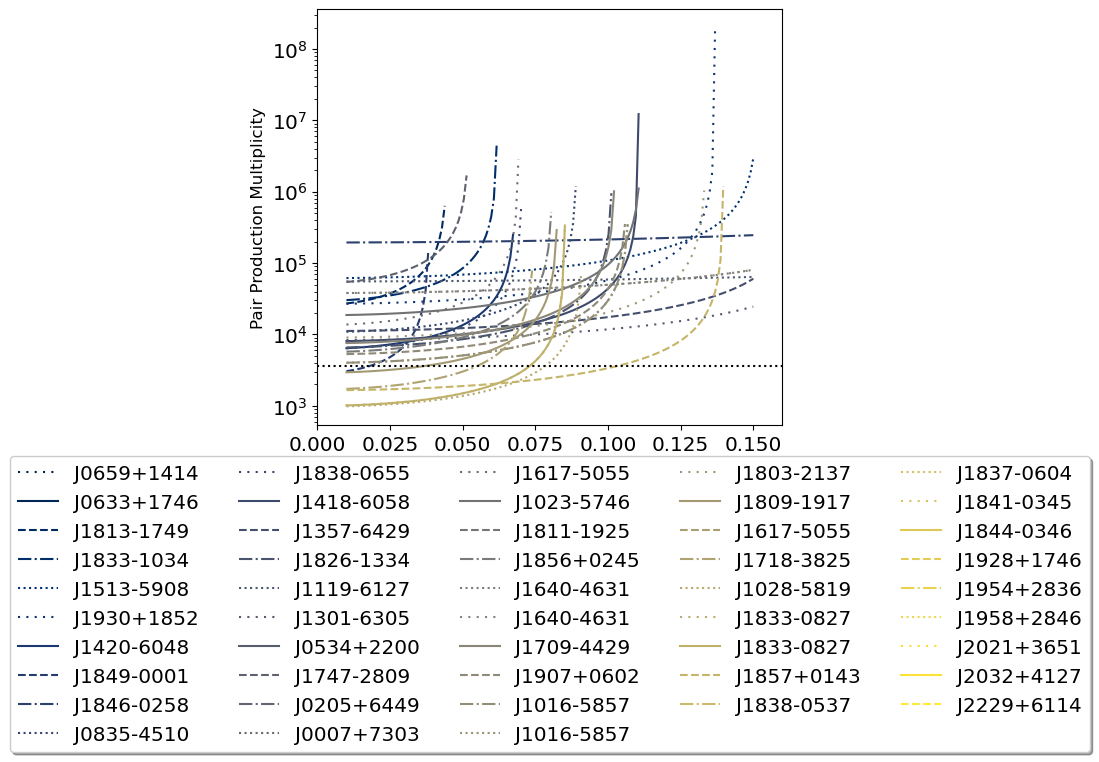

In [15]:
plt.figure(figsize=(6,6))
lines = [(0, (1, 3)),"-","--","-.",":"]
linecycler = cycle(lines)
#Now plot how the pair-production multiplicity varies with P0. 
color = cm.cividis(np.linspace(0, 1, len(df)))
#Only first 10 in df, as len(df) is a crowded plot
for i in range(len(df)):
    
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])
    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i],linestyle=next(linecycler),color=color[i])
    
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.ylabel("Pair Production Multiplicity",fontsize=12)
plt.xlabel("Birth Period (s)",fontsize=12)
ax=plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

None

### Initial spin period
* Use eqn(6) of van der Swaluw - ratio of $R_{pwn}/R_{snr}$ can be obtained for e.g. table 1 of halo paper
 - doing this for the full table 2 will need a literature search
* Current spin period via ATNF catalogue
* Moment of inertia $I$ can be calculated, but $\eta_1$ and $\eta_3$ need to be assumed. 


Problem: $E_0$ - feels dangerous to assume this. 

Determine dependency of $P_0$ on assumed $E_0$? Or could assume a standard evolution of $\dot{E}$ towards present day values. 

In [16]:
#Expression for P0 from ratio based on van de Swaluw et al. 

def P0(R_pwn,R_snr,P_t,E0=1e51*u.erg,I=1.4e45*u.g*u.cm**2):
    eta_1 = 1.0
    eta_3 = 1.02
    R_ratio = R_pwn/(eta_3*R_snr)
    P_ratio = 2.*np.pi/P_t
    
    EI_term = 2.*E0 / (eta_1*I)
#     print(EI_term.to(1./u.s**2))
    
    P0 = (EI_term*R_ratio**3. + P_ratio**2)**-0.5
    P0 *= 2*np.pi
    
    return P0.to(u.s)

In [17]:
# atnf_names

In [18]:
#Reduced selection of PWNe (table 1 of halo paper)
bothradii = df['R_PWN [pc]'].notna()& df['R_SNR [pc]'].notna() #& table["F0"].notna() & table["F1"].notna()
print(len(df['Name'][bothradii].to_numpy()))
Names = df['Name'][bothradii].to_numpy()
Ratnf = df['ATNF J name'][bothradii].to_numpy()#add J1825, Geminga
Rsnr = df['R_SNR [pc]'][bothradii].to_numpy()*u.pc #Assume Crab SNR size = PWN size
Rpwn = df['R_PWN [pc]'][bothradii].to_numpy()*u.pc #making a guess for J1825
print(Names)

6
['J1833-105' 'J1514-591' 'J1930+188' 'J1846-029' 'J0835-455' 'G0.9+0.1']


In [19]:
Patnf = np.zeros(len(Ratnf))
for i in range(len(Ratnf)):
    index = np.where(atnf_names==Ratnf[i])[0][0]
    Patnf[i] = period_atnf[index]

print(Patnf)

[0.06188365 0.15158194 0.13685505 0.32657129 0.08932839 0.05215285]


In [20]:
P_0 = P0(Rpwn,Rsnr,Patnf*u.s)

In [21]:
# print(P_0,Patnf)
#Ratio of P0 derived to current period in ATNF:
print(P_0 / (Patnf*u.s))

[0.53251237 0.10053579 0.30180072 0.1554733  0.12159543 0.91797585]


Now we have both $k$ as a function of $P_0$, for all pulsars/pwne considered in the halos paper, and constraints on $P_0$ for a subset of pwne for which we have more information (e.g. table 1 of the halos paper). 

Dashed lines below indicate the evaluated $P_0$ from the radius ratio. 
Where the lines of the same colour intersect, this gives the pair-production multiplicity for that PWN. 


0.06188365001063282 101.53223518813148 1 / s
J1833-1034 p= 0.06188365001063282 pdot 2.020149962455173e-13 nel 4.5617898083450285e+48 tau [  4726.79914501   4701.8637301    4674.69052154   4645.27951933
   4613.63072348   4579.74413398   4543.61975083   4505.25757404
   4464.6576036    4421.81983952   4376.74428179   4329.43093041
   4279.87978539   4228.09084672   4174.0641144    4117.79958844
   4059.29726884   3998.55715558   3935.57924868   3870.36354814
   3802.91005394   3733.2187661    3661.28968462   3587.12280949
   3510.71814071   3432.07567829   3351.19542222   3268.0773725
   3182.72152914   3095.12789213   3005.29646148   2913.22723718
   2818.92021923   2722.37540764   2623.5928024    2522.57240351
   2419.31421098   2313.8182248    2206.08444498   2096.11287151
   1983.90350439   1869.45634363   1752.77138922   1633.84864117
   1512.68809947   1389.28976412   1263.65363512   1135.77971248
   1005.6679962     873.31848627    738.73118269    601.90608546
    462.84319459   

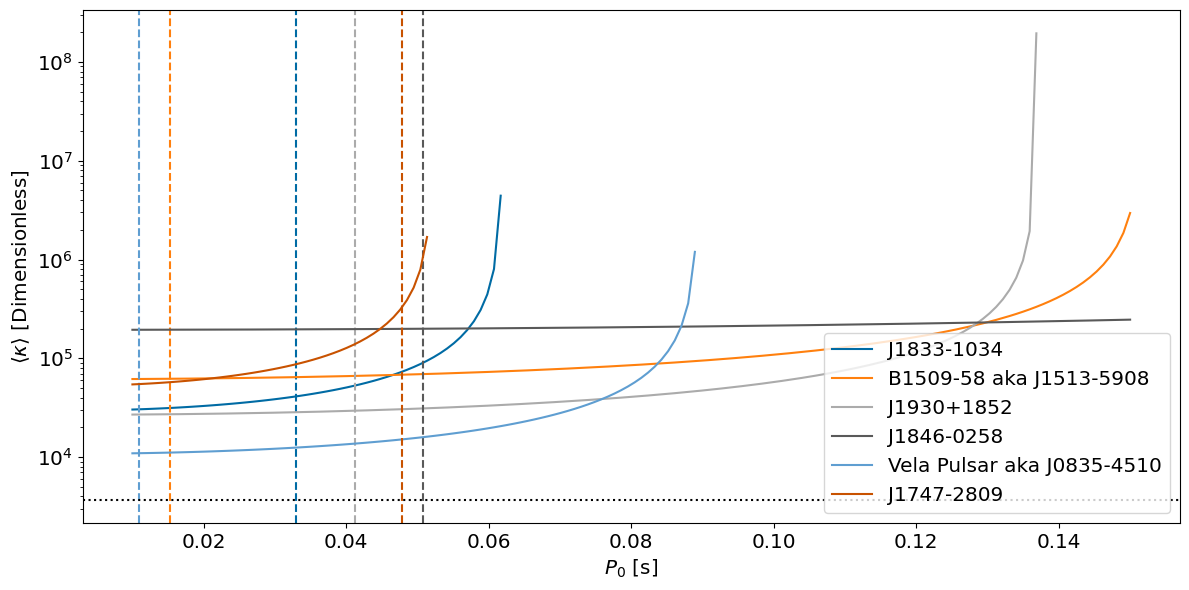

In [22]:
#Add these derived P0s to the plot above of k vs P0. 
fig=plt.figure(figsize=(12,6))
for index in range(len(Ratnf)):#len(df)):

    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    #if np.isnan(k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()]):
    #    continue
    print(Ratnf[index],"p=",period_atnf[i],'pdot',pdot_atnf[i],'nel',Nel[i],'tau',tau_p0)
    if Ratnf[index]=='J0835-4510':
        p = plt.plot(test_p0[mask],k_p0[mask],label='Vela Pulsar aka '+str(Ratnf[index]))
    elif Ratnf[index]=='J1513-5908':
        p = plt.plot(test_p0[mask],k_p0[mask],label='B1509-58 aka '+str(Ratnf[index]))
    else: 
        p = plt.plot(test_p0[mask],k_p0[mask],label=Ratnf[index])

    plt.axvline(P_0[index].value,linestyle='--',color=p[0].get_color())
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.legend(ncols=1,loc=4)
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.tight_layout()
plt.savefig('kappaplot.png',dpi=300)

0.06188365001063282 3.14e+13 101.53223518813148 1 / s [-3.28679361e+35 -3.28551792e+35 -3.28424297e+35 -3.28296876e+35
 -3.28169530e+35 -3.28042257e+35 -3.27915059e+35 -3.27787934e+35
 -3.27660884e+35 -3.27533907e+35 -3.27407004e+35 -3.27280175e+35
 -3.27153419e+35 -3.27026738e+35 -3.26900129e+35 -3.26773595e+35
 -3.26647133e+35 -3.26520745e+35 -3.26394431e+35 -3.26268189e+35
 -3.26142021e+35 -3.26015926e+35 -3.25889905e+35 -3.25763956e+35
 -3.25638080e+35 -3.25512277e+35 -3.25386547e+35 -3.25260890e+35
 -3.25135306e+35 -3.25009795e+35 -3.24884356e+35 -3.24758989e+35
 -3.24633696e+35 -3.24508474e+35 -3.24383325e+35 -3.24258249e+35
 -3.24133245e+35 -3.24008313e+35 -3.23883453e+35 -3.23758666e+35
 -3.23633951e+35 -3.23509307e+35 -3.23384736e+35 -3.23260237e+35
 -3.23135809e+35 -3.23011453e+35 -3.22887170e+35 -3.22762957e+35
 -3.22638817e+35 -3.22514748e+35] erg / s -3.365236437869983e+37 cm2 g / s3
0.15158194339345915 1.88e+14 41.45075044242182 1 / s [-9.13032498e+33 -9.13012947e+33 -9.1

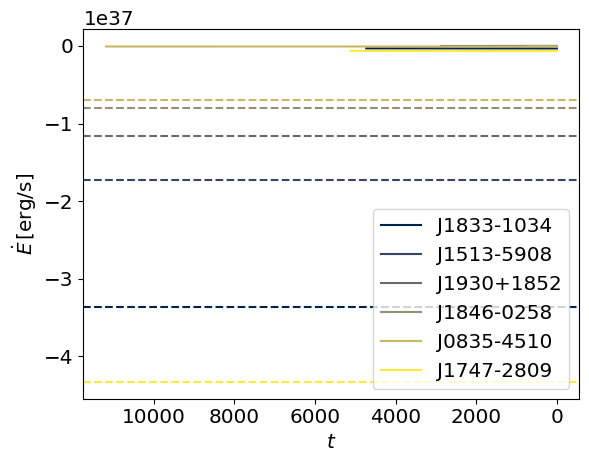

In [23]:
#Check EDot Calculations

Bp=10**12*u.cm**-0.5*u.g**0.5/u.s
a=(10*u.km).to(u.cm)
theta=np.pi/4
I=10**45*u.cm**2*u.g
color = cm.cividis(np.linspace(0, 1, len(Ratnf)))
j=0
for index in range(len(Ratnf)):
    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],10*u.ms)
    t=np.linspace(0*u.s,tau_p0)
    fatnf=2*np.pi/period_atnf[i]/u.s
    tau0atnf=(6*I*c.c.cgs**3)/(Bp**2*a**6*np.sin(theta)**2*fatnf**2)

    edot_pwn=-1*(2/(3*c.c.cgs**3))*(Bp**2*a**6/4)*((np.sin(theta)**2*fatnf**4)/(1+2*t/tau0atnf)**2)
    edot_pwn=edot_pwn.to(u.erg/u.s)
    plt.plot(t,edot_pwn.value,label=Ratnf[index],color=color[j])
    dotE=-4*np.pi**2*I*pdot_atnf[i]/period_atnf[i]**3/u.s**3
    print(period_atnf[i],'%.2e'%tau0atnf.value,fatnf,edot_pwn,dotE)
    plt.axhline(dotE.value,color=color[j],linestyle='dashed')
    j+=1
ax=plt.gca()
ax.invert_xaxis()

plt.xlabel(r"$t$")
plt.ylabel("$\dot{E}\,\mathrm{[erg/s]}$")
plt.legend(ncols=1,loc=4)

0.06188365001063282 101.53223518813148 1 / s
J1833-1034 p= 0.06188365001063282 P0= 0.032953808907644225 s 56 kappa= 40771.597115051736
J1833-1034 0.032953808907644225 s 0.032953808907644225 s 0.032953808907644225 s
0.15158194339345915 41.45075044242182 1 / s
J1513-5908 p= 0.15158194339345915 P0= 0.015239410525787624 s 150 kappa= 62102.66504700781
J1513-5908 0.015239410525787624 s 0.015239410525787624 s 0.03827537618747317 s
0.136855046957 45.91124293102446 1 / s
J1930+1852 p= 0.136855046957 P0= 0.04130295131654276 s 136 kappa= 29458.959941230816
J1930+1852 0.04130295131654276 s 0.04130295131654276 s 0.04130295131654276 s
0.3265712883437141 19.239858283458698 1 / s
J1846-0258 p= 0.3265712883437141 P0= 0.0507731171134841 s 150 kappa= 199098.17796125513
J1846-0258 0.0507731171134841 s 0.0507731171134841 s 0.0507731171134841 s
0.08932838502359318 70.33806001888524 1 / s
J0835-4510 p= 0.08932838502359318 P0= 0.010861923156129938 s 85 kappa= 10952.777540277766
J0835-4510 0.010861923156129938

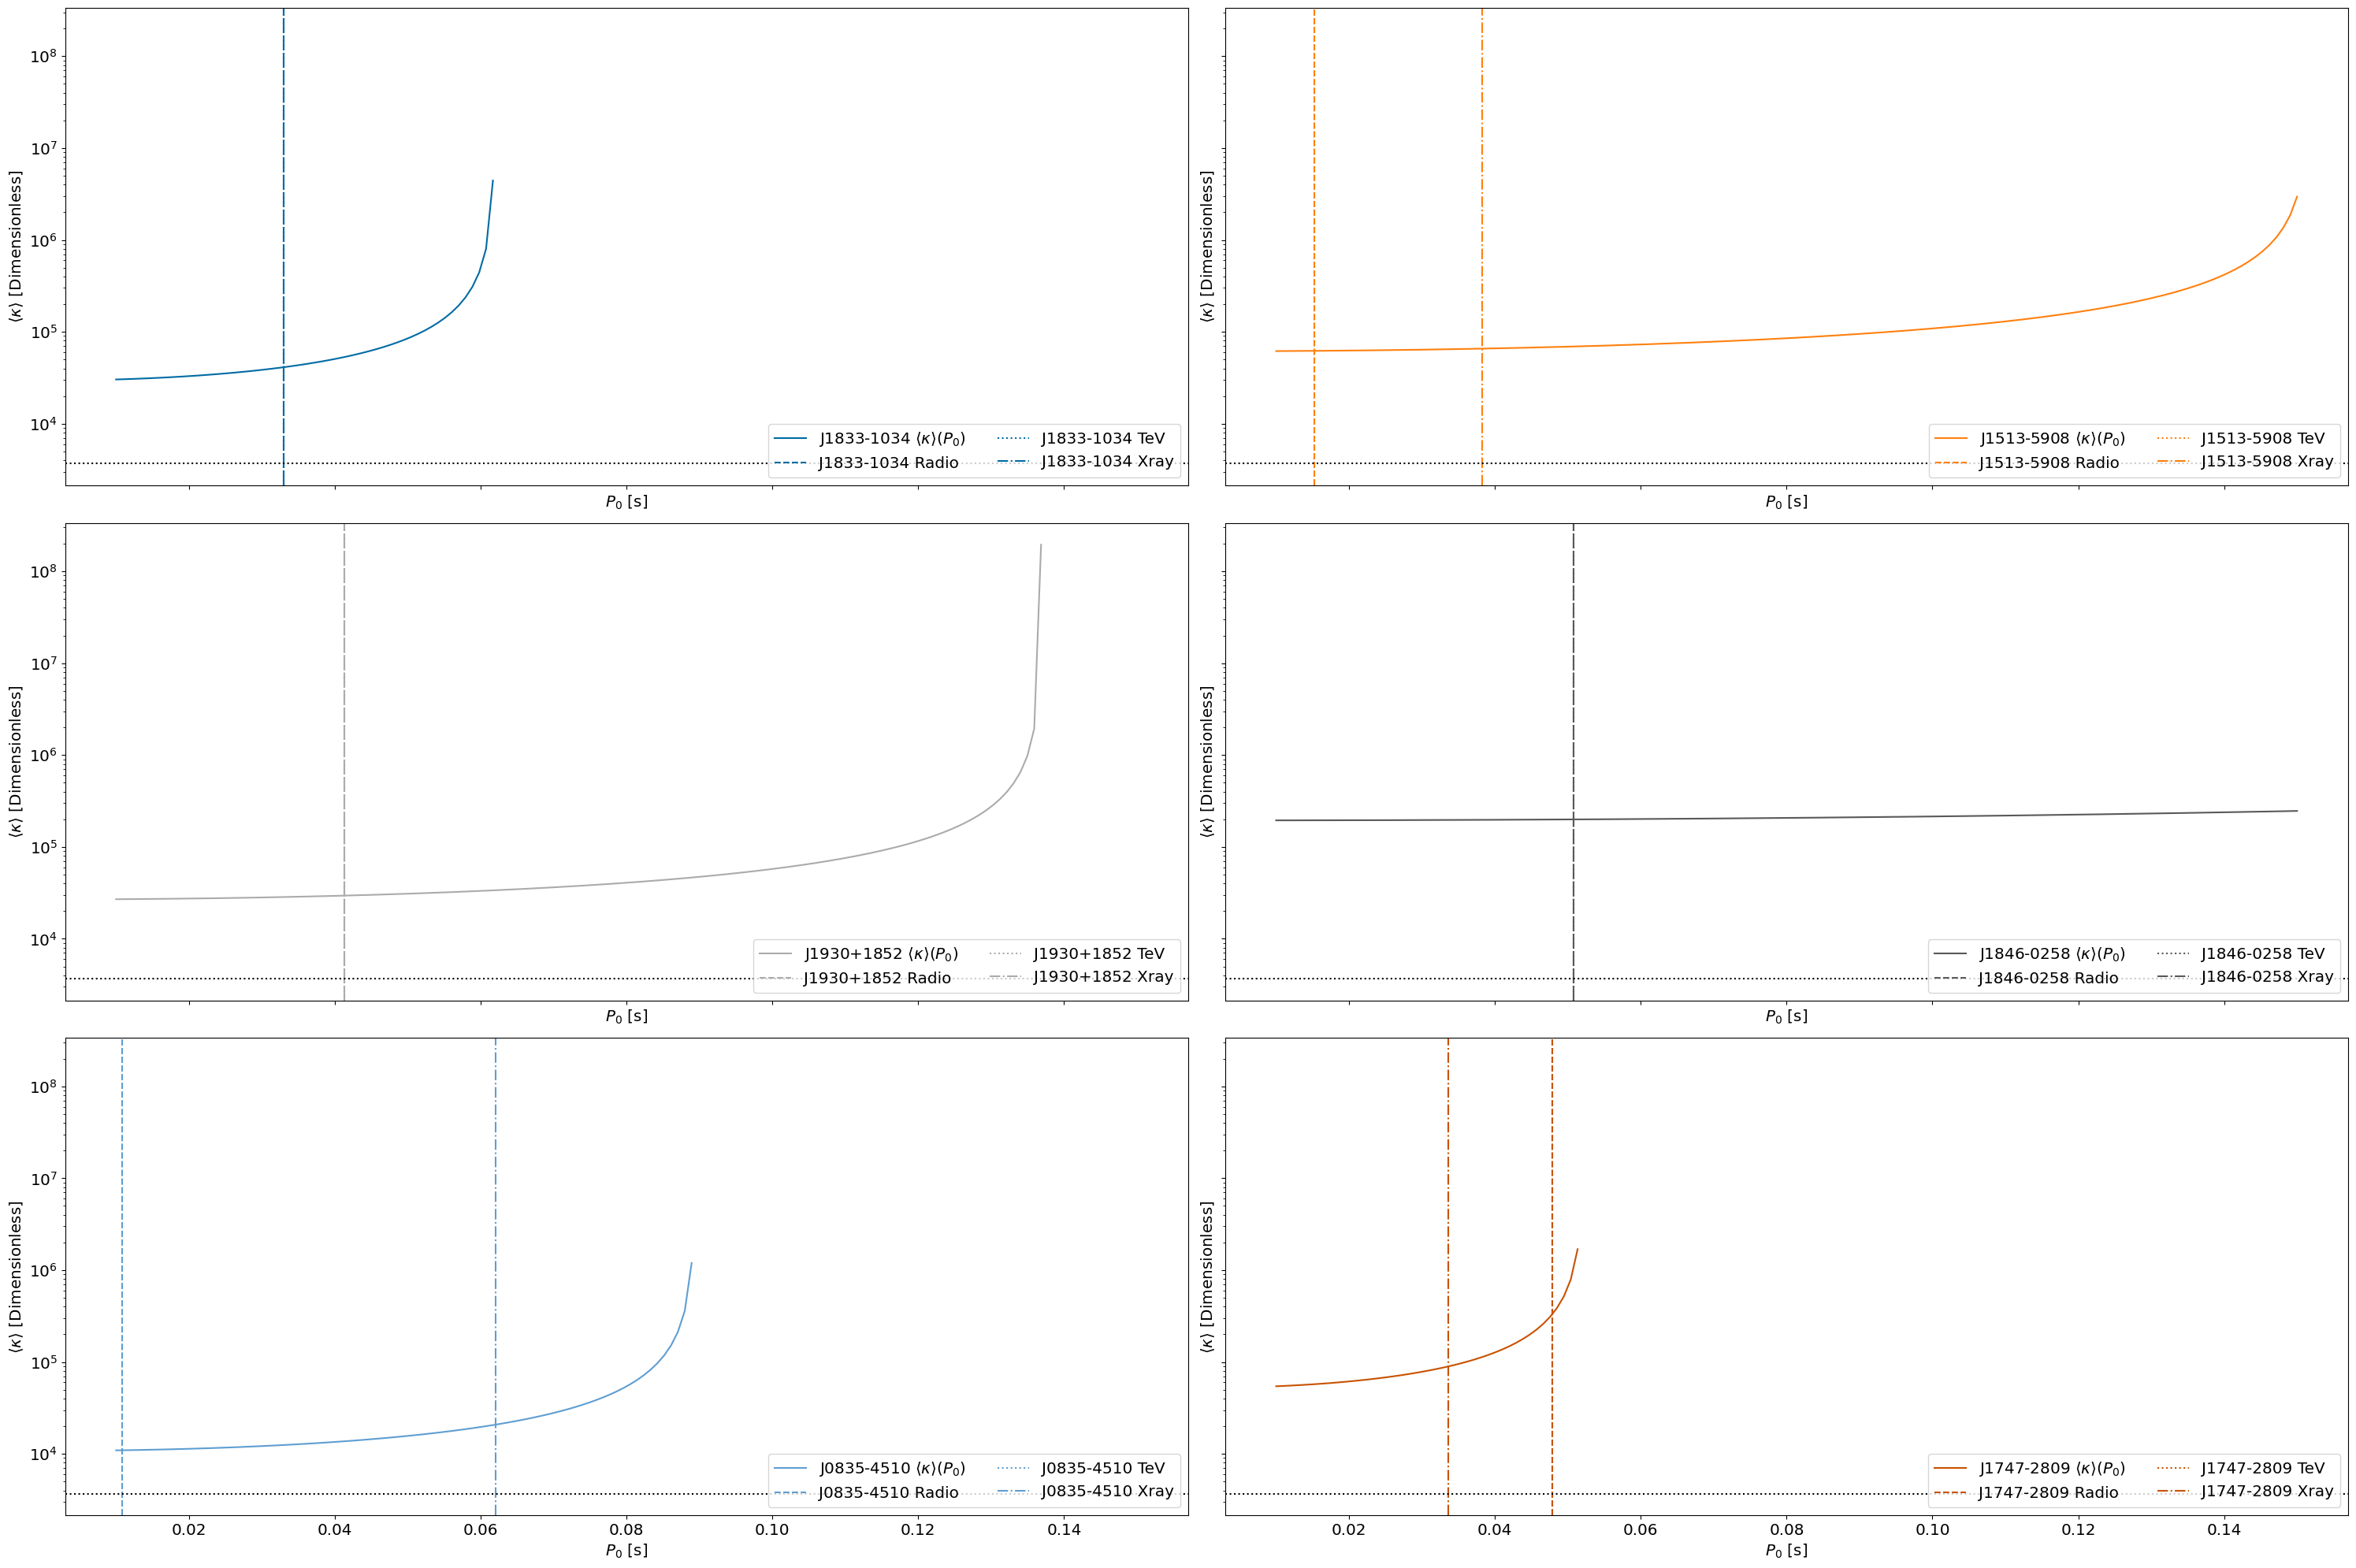

In [24]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = cycle(prop_cycle.by_key()['color'])


R_TeV=df['R_PWN [pc]'][bothradii].to_numpy()*u.pc
R_Xray=df['R_Xray [pc]'][bothradii].to_numpy()*u.pc

P_0 = P0(Rpwn,Rsnr,Patnf*u.s)
P_TeV = P0(R_TeV,Rsnr,Patnf*u.s)
P_Xray = P0(R_Xray,Rsnr,Patnf*u.s)
fig,axs=plt.subplots(3,2,sharex=True,sharey=True,figsize=(30,20))
axs=axs.reshape(-1)
for index in range(len(Ratnf)):#len(df)):
    mycol=next(colors)
    i = np.where(atnf_names==Ratnf[index])[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    print(Ratnf[index],"p=",period_atnf[i],"P0=",P_0[index],sum(mask),'kappa=',k_p0[np.abs(P_0[index].value-test_p0[mask].value).argmin()])
    
    p = axs[index].plot(test_p0[mask],k_p0[mask],color=mycol, label=Ratnf[index]+r' $\langle \kappa \rangle (P_0)$')
    axs[index].axvline(P_0[index].value,linestyle='--',label=Ratnf[index]+' Radio',color=mycol)
    axs[index].axvline(P_TeV[index].value,linestyle=':',label=Ratnf[index]+' TeV',color=mycol)
    axs[index].axvline(P_Xray[index].value,linestyle='-.',label=Ratnf[index]+' Xray',color=mycol)
    print(Ratnf[index],P_0[index],P_TeV[index],P_Xray[index])
    
    axs[index].semilogy()
    #axs[index].set_ylim(100.,1e6)
    #axs[index].set_xlim(0.0,0.16)
    axs[index].set_ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
    axs[index].set_xlabel("$P_0\ \mathrm{[s]}$")
    axs[index].legend(ncols=2,loc=4)
    axs[index].axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.tight_layout()
plt.savefig('rplot.png',dpi=300)

In [25]:
2*c.m_p/c.m_e

<Quantity 3672.30534688>

The desired pair-production multiplicity for hadrons from the pulsar surface to reach the PWN is that 
$k \lesssim 2m_p/m_e = 3672 $ which is given by the horizontal dotted line. 

We can therefore exclude the PWNe studied here as being systems in which that could have happened, with the possible exception of Vela and J1825-137. 

1.9692251953896415e+49
0.3265712883437141 19.239858283458698 1 / s
5.157494559353824e+47
0.3265712883437141 19.239858283458698 1 / s
5.157494559353822e+47
0.3265712883437141 19.239858283458698 1 / s
5.157494559353823e+47
0.3265712883437141 19.239858283458698 1 / s
5.157494559353823e+47
0.3265712883437141 19.239858283458698 1 / s


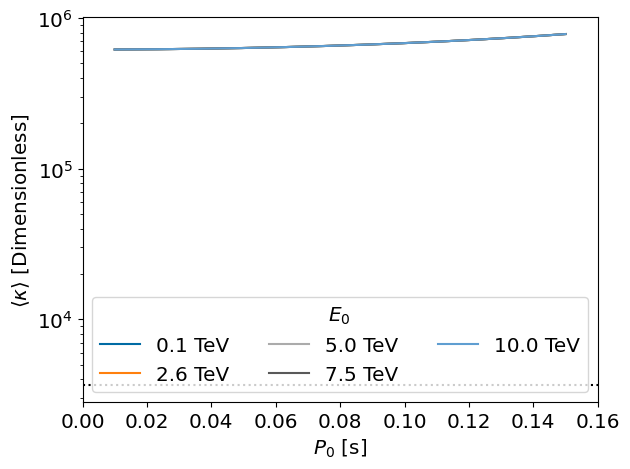

In [26]:
E0range=np.linspace(0.1,10,5)*u.TeV
E2 = 10. *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam


for index in range(len(E0range)):#len(df)):
    E0 = E0range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.1f'%E0range[index].value+' TeV')
    
plt.semilogy()
#plt.ylim(100.,1e6)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.legend(title='$E_0$',ncols=3,loc=4,title_fontsize='x-large')
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')

plt.tight_layout()
plt.savefig('e0scan.png',dpi=300)

2.1998138454322488e+47
0.3265712883437141 19.239858283458698 1 / s
5.157494559353822e+47
0.3265712883437141 19.239858283458698 1 / s
8.523114408763807e+47
0.3265712883437141 19.239858283458698 1 / s


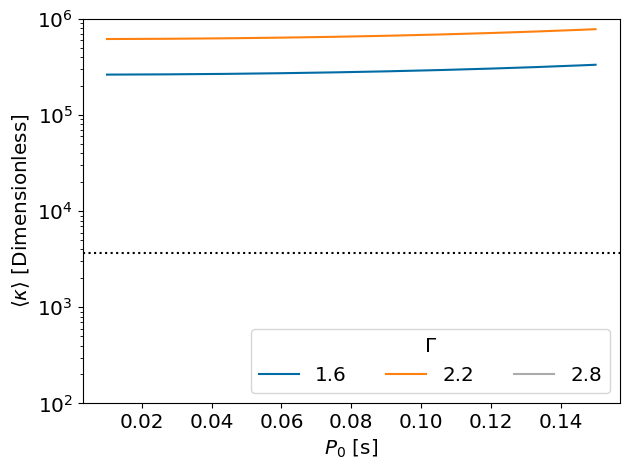

In [27]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gamrange = np.asarray([1.6,2.2,2.8]) #try 1.6-2.6



for index in range(len(Gamrange)):#len(df)):
    Gam = Gamrange[index]
    pow2 = 2-Gam
    pow1 = 1-Gam
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.1f'%Gamrange[index])
    
plt.semilogy()
plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$\Gamma$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('gamscan.png',dpi=300)

7.912414054659201e+47
0.3265712883437141 19.239858283458698 1 / s
6.208755008159554e+47
0.3265712883437141 19.239858283458698 1 / s
5.157494559353822e+47
0.3265712883437141 19.239858283458698 1 / s


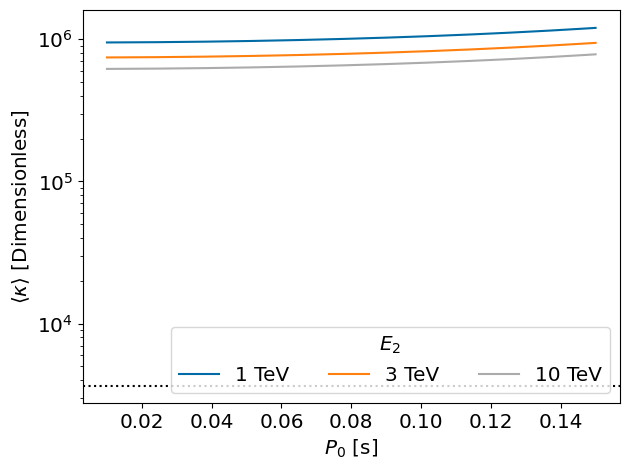

In [28]:
E2range=np.asarray([1,3,10])*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam


for index in range(len(E2range)):#len(df)):
    E2 = E2range[index]
    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    print(Nel[i])
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    p = plt.plot(test_p0[mask],k_p0[mask],label='%.0f'%E2range[index].value+' TeV')
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$E_2$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('e2scan.png',dpi=300)

0.3265712883437141 19.239858283458698 1 / s
0.3265712883437141 19.239858283458698 1 / s
0.3265712883437141 19.239858283458698 1 / s


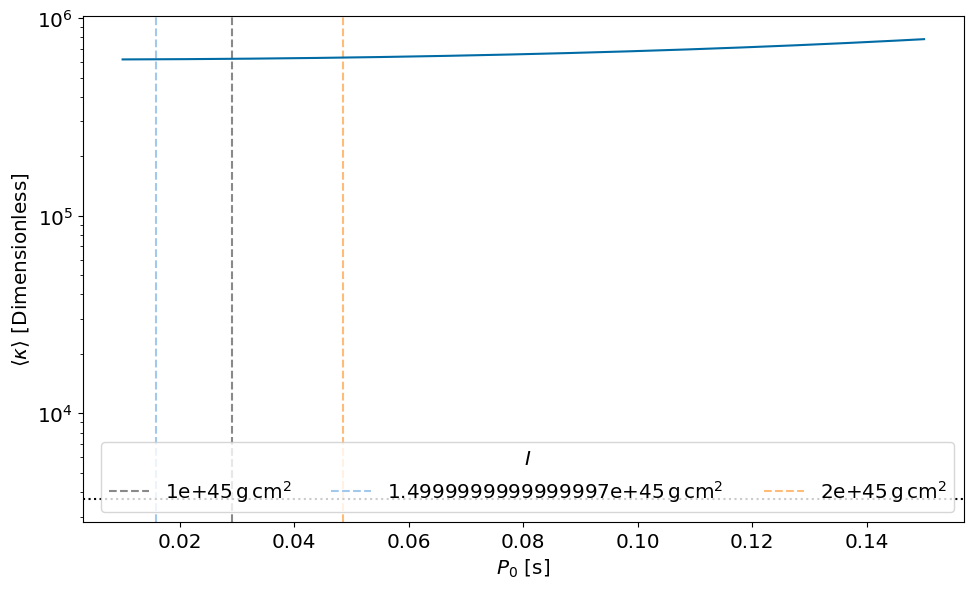

In [29]:
E2=10*u.TeV
E0 = 1 *u.TeV #1, 3 or 10
E1 = 0.1 *u.TeV
Gam = 2.2
pow2 = 2-Gam
pow1 = 1-Gam
Irange=np.linspace(1e45,2e45,3)*u.g*u.cm**2
fig=plt.figure(figsize=(10,6))
for index in range(len(Irange)):#len(df)):
    P_0dup = P0(Rpwn,Rsnr,Patnf*u.s,I=Irange[index])

    integral2 = ((E2)**pow2 - (E1)**pow2)/(pow2*E0**(1-Gam))
    integral = ((E2/E0)**pow1 - (E1/E0)**pow1)/pow1
    k_intconst = df["Total_E [erg]"]*u.erg / integral2
    Nel = k_intconst*integral
    i = np.where(atnf_names=='J1846-0258')[0][0]
    tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
    ngj_p0 = calc_ngj(tau_p0,period_atnf[i])

    k_p0 = Nel[i] / (2.*ngj_p0)
    mask = test_p0 < period_atnf[i]*u.s
    plt.axvline(P_0dup[index].value,linestyle='--',label=str(Irange[index].value)+'$\mathrm{\,g\,cm^2}$',color=next(colors))


    

p = plt.plot(test_p0[mask],k_p0[mask])
    
plt.semilogy()
#plt.ylim(100.,1e6)
#plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend(title='$I$',ncols=3,loc=4,title_fontsize='x-large')
plt.tight_layout()
plt.savefig('I.png',dpi=300)

Total energy 0.44803719139726317
0.10374095207436164 60.566104142516366 1 / s
6.382322036451961e+46


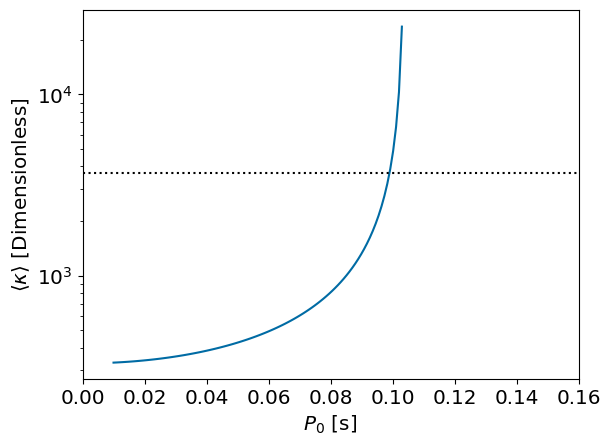

In [30]:
#Dragonfly, J2018+3651 from https://arxiv.org/pdf/1907.12121.pdf
#Approach, numerically integrate power law with exponential cutoff.

x=np.linspace(25,1e3,100)*u.TeV #Lower bound is 1 MeV. Use Cao et al threshold of 25TeV? 
E0=1*u.TeV #Pivot energy is 1 TeV
Ecut=0.9*u.PeV #Cutoff is 900 TeV
completeenergy=(x/E0)**-1.4*np.exp(-x/Ecut)#alpha is 2.4
print("Total energy",simps(completeenergy,x))
#kconst=6.1e49*u.erg/simps(completeenergy,x) #Calculate electron spectrum normalisation
kconst=3.9e48*u.erg/simps(completeenergy,x) #Dynamical model
y=kconst*(x/E0)**-2.4*np.exp(-x/Ecut) #Electron Spectrum
nel=simps(kconst*(x/E0)**-2.4*np.exp(-x/Ecut),x) #Integrate dN/dE
i=np.where(atnf_names=='J2021+3651')[0][0] #Locate pulsar and calculate ngj
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,period_atnf[i])
print(nel)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J2018x.txt',test_p0[mask].value)
np.savetxt('J2018y.txt',k_p0[mask])

0.11285464990490733 55.675023691747505 1 / s
8.542722514065713e+44 [ 5.49473923e+43  5.48620489e+43  5.47690457e+43  5.46683825e+43
  5.45600591e+43  5.44440753e+43  5.43204309e+43  5.41891256e+43
  5.40501592e+43  5.39035313e+43  5.37492416e+43  5.35872899e+43
  5.34176757e+43  5.32403988e+43  5.30554588e+43  5.28628552e+43
  5.26625877e+43  5.24546560e+43  5.22390594e+43  5.20157977e+43
  5.17848703e+43  5.15462768e+43  5.13000166e+43  5.10460893e+43
  5.07844943e+43  5.05152312e+43  5.02382992e+43  4.99536979e+43
  4.96614267e+43  4.93614850e+43  4.90538721e+43  4.87385874e+43
  4.84156303e+43  4.80850001e+43  4.77466960e+43  4.74007175e+43
  4.70470638e+43  4.66857341e+43  4.63167277e+43  4.59400439e+43
  4.55556818e+43  4.51636407e+43  4.47639197e+43  4.43565181e+43
  4.39414350e+43  4.35186694e+43  4.30882207e+43  4.26500877e+43
  4.22042698e+43  4.17507658e+43  4.12895749e+43  4.08206962e+43
  4.03441286e+43  3.98598712e+43  3.93679229e+43  3.88682827e+43
  3.83609497e+43  3.784

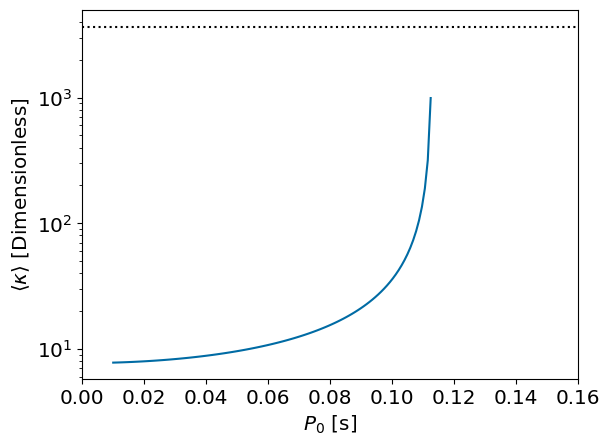

In [31]:
#J1843-0338
x=np.linspace(1e-5,740,100)*u.TeV #-5
#x=np.linspace(17.8,200,100)*u.TeV #Use HAWC energy threshold of 56 TeV
E0=7*u.TeV
Ecut=72*u.TeV

kconst=7.1*10**31/u.eV
nel=simps(kconst*(x/E0)**-2.17*np.exp(-x/Ecut),x) #Directly integrate spectrum
i=np.where(atnf_names=='J1844-0346')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,period_atnf[i])
print(nel,ngj_p0)
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1843x.txt',test_p0[mask].value)
np.savetxt('J1843y.txt',k_p0[mask])

0.038522586319205 163.10393220008635 1 / s
5.419356506677879e+43 erg [ 1.54509625e+45  1.52457067e+45  1.50215981e+45  1.47785231e+45
  1.45163581e+45  1.42349689e+45  1.39342108e+45  1.36139281e+45
  1.32739539e+45  1.29141098e+45  1.25342058e+45  1.21340394e+45
  1.17133958e+45  1.12720472e+45  1.08097525e+45  1.03262566e+45
  9.82129032e+44  9.29456938e+44  8.74579418e+44  8.17464904e+44
  7.58080160e+44  6.96390207e+44  6.32358250e+44  5.65945598e+44
  4.97111577e+44  4.25813439e+44  3.52006258e+44  2.75642829e+44
  1.96673552e+44  1.15046308e+44  3.07063294e+43 -5.64039443e+43
 -1.46345016e+44 -2.39180498e+44 -3.34977285e+44 -4.33805748e+44
 -5.35739941e+44 -6.40857821e+44 -7.49241487e+44 -8.60977448e+44
 -9.76156896e+44 -1.09487602e+45 -1.21723634e+45 -1.34334507e+45
 -1.47331549e+45 -1.60726741e+45 -1.74532766e+45 -1.88763051e+45
 -2.03431836e+45 -2.18554228e+45 -2.34146270e+45 -2.50225020e+45
 -2.66808631e+45 -2.83916443e+45 -3.01569087e+45 -3.19788596e+45
 -3.38598530e+45 -3.5

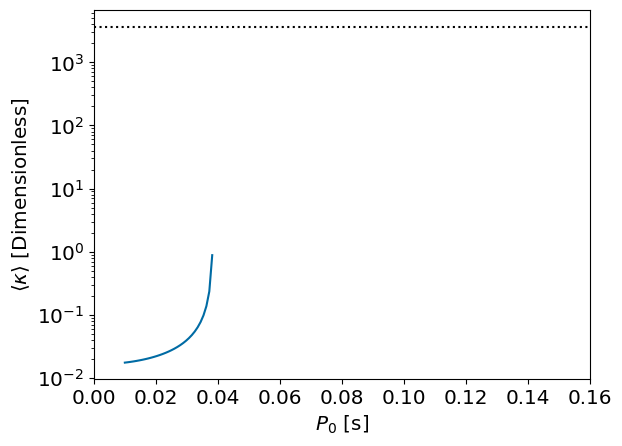

In [32]:
#J1849-000 https://iopscience.iop.org/article/10.3847/1538-4357/acebce/pdf, now using total energy
#rather than kconst

E0=10*u.TeV
#E1=0.1*u.TeV From paper in final column
E1=0.501*u.TeV #From H.E.S.S. GPS
E2=100*u.TeV
kconst=10**31.98/u.eV
gam1=-2.46
toten=2.8*10**47*u.erg
x=np.linspace(0.1,1e3,100)*u.TeV #

y=(x/E0).to(u.eV/u.eV)**(gam1)

kconst=toten/simps(y,x)

nel=kconst*((E2/E0).to(u.eV/u.eV)**(gam1+1)/(gam1+1)-(E1/E0).to(u.eV/u.eV)**(gam1+1))/(gam1+1)
i=np.where(atnf_names=='J1849-0001')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,period_atnf[i])
print(nel,ngj_p0)

k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1849x.txt',test_p0[mask].value)
np.savetxt('J1849y.txt',k_p0[mask].value)

0.10148679420759428 61.91135857860622 1 / s


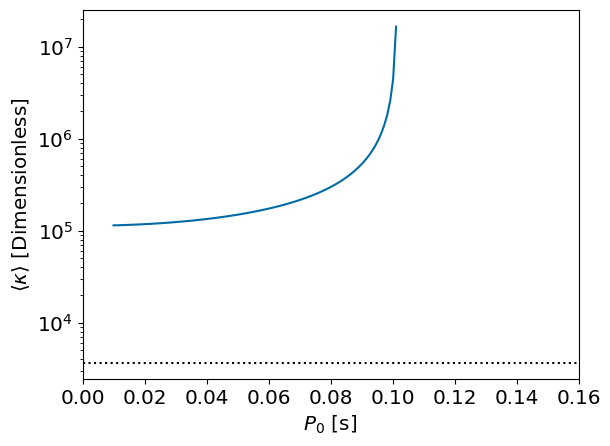

In [33]:
#J1825-137

#e1=1*u.TeV 
e1=0.396*u.TeV #HESS GPS
ebreak=0.9*u.TeV
gam1=-1.4
gam2=-3.25
Etot=5.5e48*u.erg
x1=np.linspace(0.7,ebreak.value,100)*u.TeV
x2=np.linspace(ebreak.value,12,100)*u.TeV
y1=x1**(gam1+1)/gam1
y2=x2**(gam2+1)/gam2
z1=x1**gam1
z2=x2**gam2

kprop=Etot/(simps(y2,x2)+simps(y1,x1)) #Determine proportionality constant for broken power law
nel=kprop*(simps(x2,z2)+simps(x1,z1)) #Calculate electron number for broken power law

i=np.where(atnf_names=='J1826-1334')[0][0]
tau_p0 = age_p0(period_atnf[i],pdot_atnf[i],test_p0)
ngj_p0 = calc_ngj(tau_p0,period_atnf[i])
k_p0 = nel / (2.*ngj_p0)
mask = test_p0 < period_atnf[i]*u.s
plt.plot(test_p0[mask],k_p0[mask],label=atnf_names[i])
plt.semilogy()
#plt.ylim(100.,1e8)
plt.xlim(0.0,0.16)
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
np.savetxt('J1825x.txt',test_p0[mask].value)
np.savetxt('J1825y.txt',k_p0[mask].value)

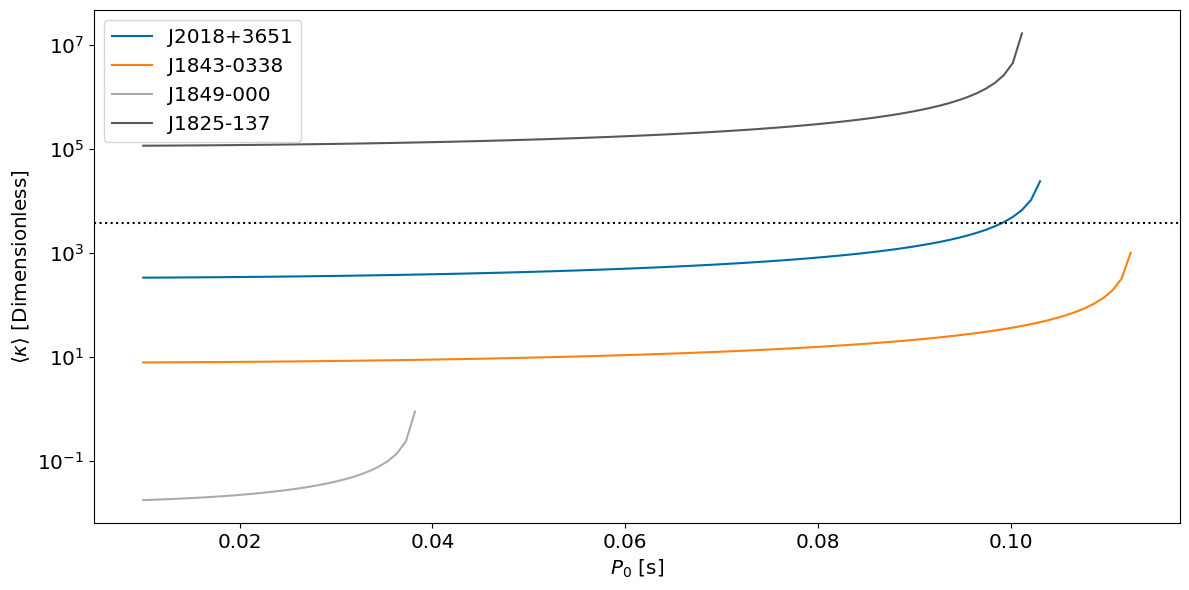

In [34]:
#LHAASO Sources Plot

fig=plt.figure(figsize=(12,6))

x2018=np.genfromtxt('J2018x.txt')
y2018=np.genfromtxt('J2018y.txt')
plt.plot(x2018,y2018,label='J2018+3651')
x1843=np.genfromtxt('J1843x.txt')
y1843=np.genfromtxt('J1843y.txt')
plt.plot(x1843,y1843,label='J1843-0338')
x1849=np.genfromtxt('J1849x.txt')
y1849=np.genfromtxt('J1849y.txt')
plt.plot(x1849,y1849,label='J1849-000')
x1825=np.genfromtxt('J1825x.txt')
y1825=np.genfromtxt('J1825y.txt')
plt.plot(x1825,y1825,label='J1825-137')
plt.ylabel(r"$\langle \kappa \rangle\ \mathrm{[Dimensionless]}$")
plt.xlabel("$P_0\ \mathrm{[s]}$")
plt.semilogy()
plt.axhline(y=2*c.m_p/c.m_e,color='k',linestyle=':')
plt.legend()
plt.tight_layout()
plt.savefig('lhassoplot.png',dpi=300)